In [1]:
import numpy as np
import h5py
import json
import sys
sys.path.append('F:\Linux')
import illustris_python as il
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap


def xyline(x, y):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


def LoadMergHist(simu, subhaloID):
    '''
    return subhalo's main progenitor and merger history with snapshot
    '''
    if (simu == 'TNG') or (simu == 'tng'):
        ldir = 'f:/Linux/localRUN/tng_DiskMerTree/%d.json' % subhaloID
    else:
        ldir = 'f:/Linux/localRUN/il1_DiskMerTree/%d.json' % subhaloID
    
    with open(ldir) as f:
        data = json.load(f)
    
    Main = np.array(data['Main'])
    return dict(zip(Main[:, 0], Main[:, 1])), np.array(data['Mergers'])

def HistValAndBin(nums, bins, more=0, mask=0):
    if mask == 1:
        reMask = []

    val = []
    tmp = nums[nums < bins[1]]
    if mask == 1:
        reMask.append(nums < bins[1])
    val.append(len(tmp))

    for i in range(1,len(bins)-1):
        tmp = nums[(nums > bins[i]) & (nums <= bins[i+1])]
        val.append(len(tmp))
        if mask == 1:
            reMask.append((nums > bins[i]) & (nums <= bins[i+1]))

    if more == 1:
        tmp = nums[nums > bins[-1]]
        val.append(len(tmp))
        if mask == 1:
            reMask.append(nums > bins[-1])

    if mask == 0:
        return np.array(val)
    else:
        return np.array(val), np.array(reMask)

def ErrorBarMedian(data):
    #return 25%, 50%, 75%
    if len(data) == 0:
        return 0, 0, 0
    elif len(data) < 3:
        return 0, np.median(data), 0
    else:
        data.sort()
        return data[int(len(data) / 4)], np.median(data), data[int(len(data) * 0.75)]

def Ydata(simu, ids, rawdata, SnapList, Redshift):
    dataWithZ = {}
    for x in Redshift:
        dataWithZ[x] = []
    #all each halo's information into 'dataWithZ'
    for subID in ids:
        data = []
        prog = LoadMergHist(simu, subID)[0]
        plot = 1
        for snap in SnapList:
            try:
                haloID = prog[snap]
                data.append(rawdata[snap][haloID])
            except:
                plot = 0       
            
        if plot:
            for i in range(len(data)):
                dataWithZ[Redshift[i]].append(data[i])

    #calculate Error bar
    plotdata = [[], [], []]
    for i in range(len(data)):
        d0, d1, d2 = ErrorBarMedian(dataWithZ[Redshift[i]])
        plotdata[0].append(d0)
        plotdata[1].append(d1)
        plotdata[2].append(d2)
    plotdata = np.array(plotdata)
    Err = np.vstack((plotdata[1,:] - plotdata[0,:], plotdata[2,:] - plotdata[1,:]))
    return plotdata[1,:], Err
    
'''
snap_135 z=0
snap_127 z=0.1
snap_120 z=0.2
snap_113 z=0.31
snap_108 z=0.4
snap_103 z=0.5
snap_85 z=1.0
snap_75 z=1.53
snap_68 z=2.0
'''




In [6]:
l1_snapshot = [135, 127, 120, 113, 103, 108, 95, 85, 75, 68, 64, 60]
tng_snapshot = [99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 29, 25]
Redshift = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0]
Redshift = np.array(Redshift)

In [2]:
bar2bar = np.load('F:/npy/bar2bar.npy',allow_pickle=1).item()
bar2disk = np.load('f:/npy/bar2no.npy',allow_pickle=1).item()
tng_BHMass = {}
tng_BHdot = {}

tng_SFR = {}
tng_GF = {}

for snap in tng_snapshot:
    BHmas = il.func.loadSubhalos('TNG', snap, 'SubhaloBHMass')
    dot = il.func.loadSubhalos('TNG', snap, 'SubhaloBHMdot')
    tng_BHMass[snap] = BHmas
    tng_BHdot[snap] = dot

    sfr = il.func.loadSubhalos('TNG', snap, 'SubhaloSFR')
    mas = il.func.loadSubhalos('TNG', snap, 'SubhaloMassInHalfRadType')
    Gf = mas[:, 0] / (mas[:, 4] + mas[:, 0])
    Gf[np.isnan(Gf)] = 0
    tng_GF[snap] = Gf
    tng_SFR[snap] = sfr


d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [3]:
il1_BHMass = {}
il1_BHdot = {}

il1_SFR = {}
il1_GF = {}
for snap in il1_snapshot:
    mas = il.func.loadSubhalos('il1', snap, 'SubhaloBHMass')
    dot = il.func.loadSubhalos('il1', snap, 'SubhaloBHMdot')
    il1_BHMass[snap] = mas
    il1_BHdot[snap] = dot
    
    sfr = il.func.loadSubhalos('il1', snap, 'SubhaloSFR')
    mas = il.func.loadSubhalos('il1', snap, 'SubhaloMassInHalfRadType')
    Gf = mas[:, 0] / (mas[:, 4] + mas[:, 0])
    Gf[np.isnan(Gf)] = 0
    il1_GF[snap] = Gf
    il1_SFR[snap] = sfr

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [4]:
il1_barID = np.load('f:/Linux/localRUN/barredID_il1.npy')
il1_diskID = np.load('f:/Linux/localRUN/diskID_il1.npy')

tng_barID = np.load('f:/Linux/localRUN/barredID_4WP_TNG.npy')
tng_diskID = np.load('f:/Linux/localRUN/diskID_4WP.npy')

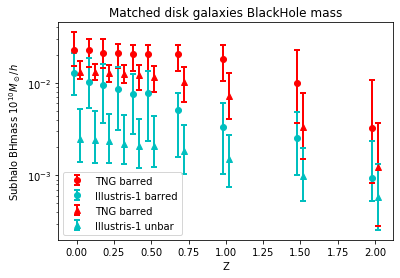

In [7]:
tng_ids = bar2bar.keys()
il1_ids = bar2bar.values()

tng_mass_Y, tng_Err = Ydata('TNG', tng_ids, tng_BHMass, tng_snapshot, Redshift)
il1_mass_Y, il1_Err = Ydata('il1', il1_ids, il1_BHMass, il1_snapshot, Redshift)

tng_ids = bar2disk.keys()
il1_ids = bar2disk.values()

tng_mass_Y_2, tng_Err_2 = Ydata('TNG', tng_ids, tng_BHMass, tng_snapshot, Redshift)
il1_mass_Y_2, il1_Err_2 = Ydata('il1', il1_ids, il1_BHMass, il1_snapshot, Redshift)


#plot info
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Z')
ax.set_ylabel(r'Subhalo BHmass $10^{10} M_\odot/h$')
ax.set_yscale("log")
# ax.set_xlim(-0.4, 0.4)
# ax.set_ylim(-0.4, 0.4)
ax.set_title("Matched disk galaxies BlackHole mass")

Redshift = np.array(Redshift)
#lines
ax.errorbar(Redshift-0.02, tng_mass_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o', label='TNG barred')
ax.errorbar(Redshift-0.02, il1_mass_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='c', fmt='o', label='Illustris-1 barred')

ax.errorbar(Redshift+0.02, tng_mass_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='r', fmt='^', label='TNG barred')
ax.errorbar(Redshift+0.02, il1_mass_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', label='Illustris-1 unbar')
ax.legend()
plt.savefig('f:/Linux/local_result/BH/matched_BHmass.png',dpi = 300)



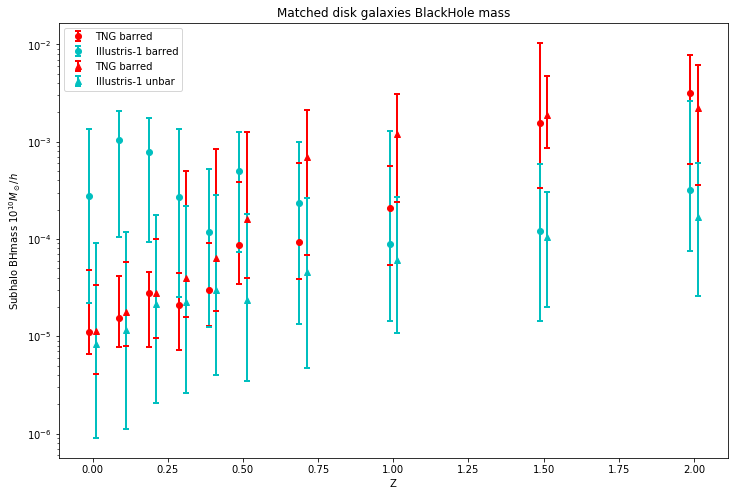

In [12]:
tng_ids = bar2bar.keys()
il1_ids = bar2bar.values()

tng_mass_Y, tng_Err = Ydata('TNG', tng_ids, tng_BHdot, tng_snapshot, Redshift)
il1_mass_Y, il1_Err = Ydata('il1', il1_ids, il1_BHdot, il1_snapshot, Redshift)

tng_ids = bar2disk.keys()
il1_ids = bar2disk.values()

tng_mass_Y_2, tng_Err_2 = Ydata('TNG', tng_ids, tng_BHdot, tng_snapshot, Redshift)
il1_mass_Y_2, il1_Err_2 = Ydata('il1', il1_ids, il1_BHdot, il1_snapshot, Redshift)


#plot info
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_xlabel('Z')
ax.set_ylabel(r'Subhalo BHmass $10^{10} M_\odot/h$')
ax.set_yscale("log")
# ax.set_xlim(-0.4, 0.4)
# ax.set_ylim(-0.4, 0.4)
ax.set_title("Matched disk galaxies BlackHole mass")

Redshift = np.array(Redshift)
#lines
ax.errorbar(Redshift-0.012, tng_mass_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o', label='TNG barred')
ax.errorbar(Redshift-0.012, il1_mass_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='c', fmt='o', label='Illustris-1 barred')

ax.errorbar(Redshift+0.012, tng_mass_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='r', fmt='^', label='TNG barred')
ax.errorbar(Redshift+0.012, il1_mass_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='^', label='Illustris-1 unbar')
ax.legend()
plt.savefig('f:/Linux/local_result/BH/matched_BHdot.png',dpi = 300)

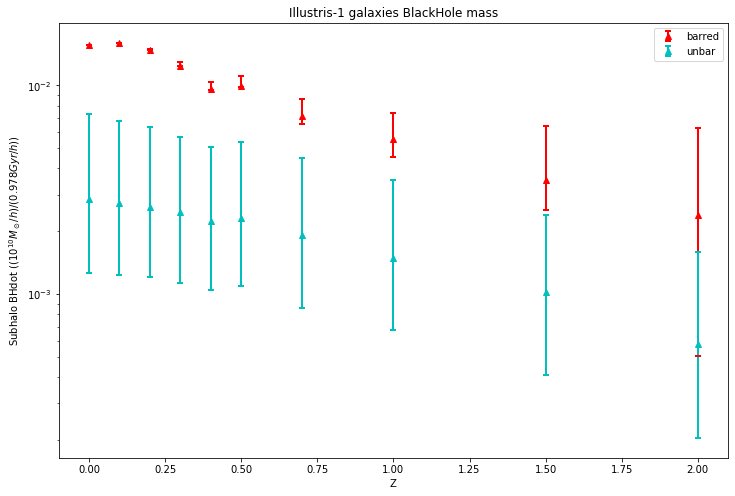

In [21]:
#Global_il1_BHmass
bar = il1_barID
unbar = []
for i in il1_diskID:
    if i not in il1_barID:
        unbar.append(i)


il1_mass_Y, il1_Err = Ydata('il1', bar, il1_BHMass, il1_snapshot, Redshift)
il1_mass_Y_2, il1_Err_2 = Ydata('il1', unbar, il1_BHMass, il1_snapshot, Redshift)


#plot info
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_xlabel('Z')
ax.set_ylabel(r'Subhalo BHmass $10^{10} M_\odot$')
ax.set_yscale("log")
# ax.set_xlim(-0.4, 0.4)
# ax.set_ylim(0.1, 0.00000001)
ax.set_title(r"Illustris-1 galaxies BlackHole mass")

Redshift = np.array(Redshift)
#lines

ax.errorbar(Redshift, il1_mass_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o', label='barred')
ax.errorbar(Redshift, il1_mass_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='o', label='unbar')
ax.legend()
plt.savefig('f:/Linux/local_result/BH/Global_il1_BHmass.png',dpi=300)

In [ ]:
#Global_il1_BHdot
il1_Y, il1_Err = Ydata('il1', bar, il1_BHdot, il1_snapshot, Redshift)
il1_Y_2, il1_Err_2 = Ydata('il1', unbar, il1_BHdot, il1_snapshot, Redshift)


#plot info
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_xlabel('Z')
ax.set_ylabel(r'Subhalo BHdot ($(10^{10} M_\odot/h) / (0.978Gyr/h)$)')
ax.set_yscale("log")
# ax.set_xlim(-0.4, 0.4)
# ax.set_ylim(0.1, 0.00000001)
ax.set_title(r"Illustris-1 galaxies BlackHole accretion rates")

Redshift = np.array(Redshift)
#lines

ax.errorbar(Redshift, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='r', fmt='o', label='barred')
ax.errorbar(Redshift, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='c', fmt='o', label='unbar')
ax.legend()
# plt.savefig('f:/Linux/local_result/BH/Global_il1_BHmass.png',dpi=300)

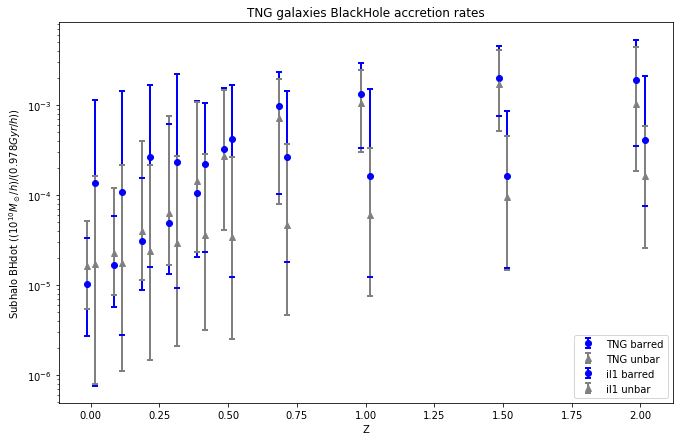

In [39]:
#Global_il1-TNG_BHdot

tng_unbar = []
for i in tng_diskID:
    if i not in tng_barID:
        tng_unbar.append(i)
        
il1_unbar = []
for i in il1_diskID:
    if i not in il1_barID:
        il1_unbar.append(i)

il1_Y, il1_Err = Ydata('il1', il1_barID, il1_BHdot, il1_snapshot, Redshift)
il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_BHdot, il1_snapshot, Redshift)
        
tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_BHdot, tng_snapshot, Redshift)
tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_BHdot, tng_snapshot, Redshift)


#plot info
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111)
ax.set_xlabel('Z')
ax.set_ylabel(r'Subhalo BHdot ($(10^{10} M_\odot/h) / (0.978Gyr/h)$)')
ax.set_yscale("log")
# ax.set_xlim(-0.4, 0.4)
# ax.set_ylim(0.1, 0.00000001)
ax.set_title(r"TNG galaxies BlackHole accretion rates")

Redshift = np.array(Redshift)
#lines

ax.errorbar(Redshift-0.015, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', label='TNG barred')
ax.errorbar(Redshift-0.015, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='grey', fmt='^', label='TNG unbar')
ax.errorbar(Redshift+0.015, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', label='il1 barred')
ax.errorbar(Redshift+0.015, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='grey', fmt='^', label='il1 unbar')
ax.legend()
plt.savefig('f:/Linux/local_result/BH/Global_tng-il1_BHdot.png',dpi=300)

In [8]:
tng_unbar = []
for i in tng_diskID:
    if i not in tng_barID:
        tng_unbar.append(i)
        
il1_unbar = []
for i in il1_diskID:
    if i not in il1_barID:
        il1_unbar.append(i)

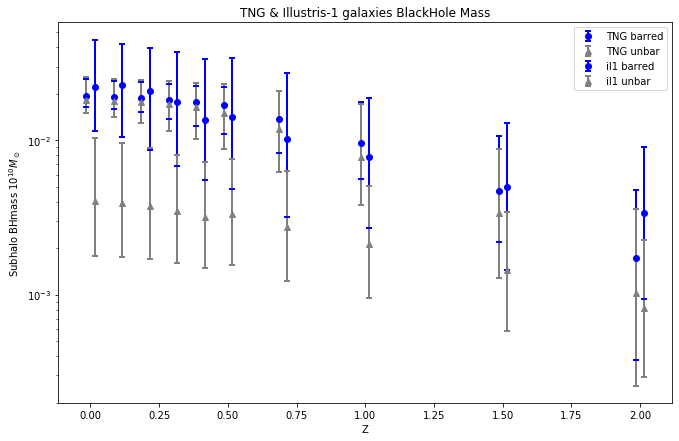

In [68]:
#Global_il1-TNG_BHmass


il1_Y, il1_Err = Ydata('il1', il1_barID, il1_BHMass, il1_snapshot, Redshift)
il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_BHMass, il1_snapshot, Redshift)
        
tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_BHMass, tng_snapshot, Redshift)
tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_BHMass, tng_snapshot, Redshift)


#plot info
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111)
ax.set_xlabel('Z')
ax.set_ylabel(r'Subhalo BHmass $10^{10} M_\odot$')
ax.set_yscale("log")
# ax.set_xlim(-0.4, 0.4)
# ax.set_ylim(0.1, 0.00000001)
ax.set_title(r"TNG & Illustris-1 galaxies BlackHole Mass")

Redshift = np.array(Redshift)
#lines

ax.errorbar(Redshift-0.015, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', label='TNG barred')
ax.errorbar(Redshift-0.015, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='grey', fmt='^', label='TNG unbar')
ax.errorbar(Redshift+0.015, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', label='il1 barred')
ax.errorbar(Redshift+0.015, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='grey', fmt='^', label='il1 unbar')
ax.legend()
# plt.savefig('f:/Linux/local_result/BH/Global_tng-il1_BHmass.png',dpi=300)

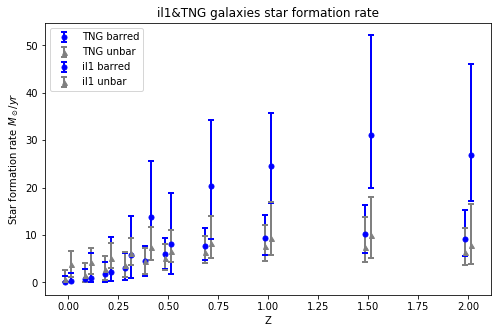

In [66]:
#Global_il1-TNG_GAS
il1_Y, il1_Err = Ydata('il1', il1_barID, il1_SFR, il1_snapshot, Redshift)
il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_SFR, il1_snapshot, Redshift)
        
tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_SFR, tng_snapshot, Redshift)
tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_SFR, tng_snapshot, Redshift)


#plot info
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.set_xlabel('Z')
ax.set_ylabel(r'Star formation rate $M_\odot/yr$')
# ax.set_yscale("log")
ax.set_xlim(-0.1, 3.1)
# ax.set_ylim(-0.02, 0.85)
ax.set_title(r"il1&TNG galaxies star formation rate")


#lines
ax.errorbar(Redshift-0.015, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5, label='TNG barred')
ax.errorbar(Redshift-0.015, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='grey', fmt='^', ms=5,label='TNG unbar')
ax.errorbar(Redshift+0.015, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o',ms=5, label='il1 barred')
ax.errorbar(Redshift+0.015, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='grey', fmt='^',ms=5, label='il1 unbar')
ax.legend()
plt.savefig('f:/Linux/local_result/SFR/Global_tng-il1_SFR.pdf')

In [33]:
plt.style.use('seaborn-bright')

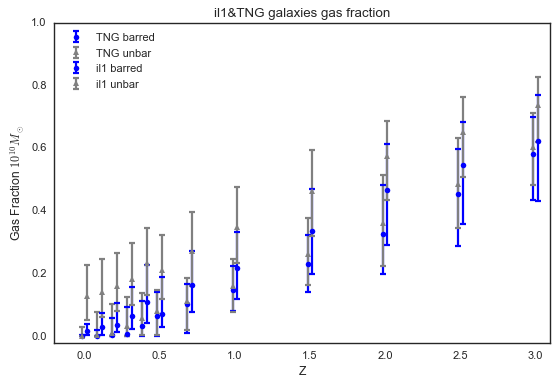

In [34]:
#Global_il1-TNG_Gasfration
il1_Y, il1_Err = Ydata('il1', il1_barID, il1_GF, il1_snapshot, Redshift)
il1_Y_2, il1_Err_2 = Ydata('il1', il1_unbar, il1_GF, il1_snapshot, Redshift)
        
tng_Y, tng_Err = Ydata('TNG', tng_barID, tng_GF, tng_snapshot, Redshift)
tng_Y_2, tng_Err_2 = Ydata('TNG', tng_unbar, tng_GF, tng_snapshot, Redshift)


#plot info
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.set_xlabel('Z')
ax.set_ylabel(r'Gas Fraction $10^{10} M_\odot$')
# ax.set_yscale("log")
ax.set_xlim(-0.1, 3.1)
ax.set_ylim(-0.02, 0.85)
ax.set_title(r"il1&TNG galaxies gas fraction")


#lines
ax.errorbar(Redshift-0.015, tng_Y, yerr=tng_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o',ms=5, label='TNG barred')
ax.errorbar(Redshift-0.015, tng_Y_2, yerr=tng_Err_2, elinewidth=2, capthick=2, capsize=3, color='grey', fmt='^',ms=5, label='TNG unbar')
ax.errorbar(Redshift+0.015, il1_Y, yerr=il1_Err, elinewidth=2, capthick=2, capsize=3, color='blue', fmt='o', ms=5,label='il1 barred')
ax.errorbar(Redshift+0.015, il1_Y_2, yerr=il1_Err_2, elinewidth=2, capthick=2, capsize=3, color='grey', fmt='^', ms=5,label='il1 unbar')

ax.legend(loc = 2)
plt.savefig('f:/Linux/local_result/SFR/Global_GasFraction.eps')

In [32]:
plt.figure

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>